#### Variational Inference with dynamic latent variable model with pyro

In this tutorial, I am going show how to build a dynamic latent variable model for psychological measurement problem. Given priors on the latent vectors and the response functions, both of the posteriors are approximated by variational methods that minimize the *distance* to the true posteriors. The variational approximation is performed using [pyro](https://pyro.ai/), a probabilistic programming language (PPL) written in Python which enables flexible and expressive deep probabilistic modeling and posterior estimation.

In [2]:
# load packages
import numpy as np
import matplotlib.pylab as plt
import torch
import pyro
from pyro.distributions import Normal, Bernoulli, MultivariateNormal
from pyro.distributions.constraints import positive
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.infer import MCMC, NUTS

from scipy.stats import norm
torch.manual_seed(8927)
np.random.seed(8927)

Throughout this tutorial, we will look at the setting of $n$ respondents answering the same set of $m$ questions repeatedly over $T$ time periods. Each respondent $i$ is associated with a $T\times 1$ latent vector $x_i$ and each question $j$ with a response slope $w_j$. Assuming the responses are binary, the probability of a positive response is modeled as a logit function: 
$$
\text{Pr}(y_{ijt}=1\mid w_j,x_{it})=\frac{1}{1+\exp(-w_j x_{it})}
$$
As the above model is not invariant to scaling, meaning multiplying and dividing the same scale to $w_j$ and $x_{it}$ will induce the same likelihood, we proceed in a Bayesian fashion by assigning appropriate priors to both $w_j$ and $x_{it}$. Specifically, we use independent uni-variate and multi-variate normal priors where the covariance matrix is determined by a RBF kernel $K_t(t,t')=\exp\big(-(t-t')^2/\ell^2\big)$ with bandwidth $\ell$.
$$
w_j\sim\mathcal{N}(0,1), \qquad x_j \sim\mathcal{MVN}(0,K_t)
$$

In [4]:
# generate synthetic data
import warnings
warnings.filterwarnings("ignore")

pyro.clear_param_store()
n = 20
m = 10
horizon = 6
true_slope = np.concatenate((np.random.normal(2,0.5,size=(m//2,)),
                                np.random.normal(-2,0.5,size=(m//2,)))).reshape(m,1)
true_x = np.concatenate((np.linspace(-2, -1, n//2),
                    np.linspace(1, 2, n//2))).reshape(n,1)
true_x = np.tile(true_x, (1, horizon))

for i in range(n):
    tmp = np.arange(horizon)
    from sklearn.metrics.pairwise import rbf_kernel
    X = np.arange(horizon).reshape(-1,1)
    cov = rbf_kernel(X, gamma = 9/horizon/horizon) + 1e-6*np.eye(horizon)

    true_x[i] += np.random.multivariate_normal(np.zeros(horizon,),cov=cov)

true_p = norm.cdf(np.dot(true_x.reshape((n,horizon,1)),np.transpose(true_slope)))
y = np.random.binomial(1, true_p)
y = torch.tensor(y).reshape((n*m*horizon,1))

The joint posterior of $\mathbf{x},\mathbf{w}$ is then
$$
p(\mathbf{x},\mathbf{w}\mid \mathbf{y})\propto \prod_i p(x_i) \prod_i p(w_j) \prod_i \prod_j \prod_t p(y_{ijt}\mid x_i, w_j)
$$
Unfortunately, closed-form posteriors of neither $w_j$ nor $x_i$ is available due to the non-Gaussian likelihood. However, one could approximate the true posterior $p(\mathbf{x},\mathbf{w}\mid \mathbf{y})$ using a parameterized distribution $q_{\phi}(\mathbf{x},\mathbf{w})$ with some parameters $\phi$ to be determined, such that the distance between $p(\mathbf{x},\mathbf{w}\mid \mathbf{y})$ and $q_{\phi}(\mathbf{x},\mathbf{w}$ is minimized. This general approach is called variational inference and $q_{\phi}(\mathbf{x},\mathbf{w}$ and $\phi$ are the variational distribution and parameters. We adopt a mean field variational approach by assuming all variables in the variational distribution can be factorized as follows:
$$
q_{\phi}(\mathbf{x},\mathbf{w})=\prod_i\prod_t q(x_{it}) \prod_j q(w_j)
$$
where all $q(x_{it})$ and $q(w_j)$ are uni-variate normal with separate mean and variance values. Note that we factorize $q(x_i)=\prod_t q(x_{it})$ so any dependency between $x_{it}$s is ignored, although one may directly use a multi-variate variational distribution on $q(x_i)$ but introduce more local variational parameters. In pyro, the prior distributions and the variational distributions are specified in `model()` and `guide()` functions separately.

In [8]:
def model(y):
    # sample w from the mv normal prior
    w = torch.zeros((m,1))
    x = torch.zeros((n,horizon))
    for i in range(m):
        w[i] = pyro.sample(f"w_{i}", Normal(0, 1))
    for i in range(n):
        x[i] = pyro.sample(f"x_{i}", MultivariateNormal(torch.zeros(horizon), torch.tensor(cov)))
    p = torch.sigmoid(torch.matmul(x.reshape((n,horizon,1)), w.t())).reshape((n*m*horizon,1))

    return pyro.sample("obs", Bernoulli(probs=p), obs=y)

def guide(y):
    # register variational parameters
    w_mu = pyro.param("w_mu", torch.zeros(m,))
    w_std = pyro.param("w_std", 0.05*torch.ones(m,), constraint=positive)

    x_mu = pyro.param("x_mu", torch.zeros((n,horizon)))
    x_std = pyro.param("x_std", 0.05*torch.ones((n,horizon)), constraint=positive)

    for i in range(n):
        pyro.sample(f"x_{i}", MultivariateNormal(x_mu[i], torch.diag(x_std[i])+1e-6*torch.eye(horizon)))

    for i in range(m):
        pyro.sample(f"w_{i}", Normal(w_mu[i], w_std[i]))

After specifying the forms of the variational distribution, one still needs to determine the values of variational parameters to make $q_{\phi}(\mathbf{x},\mathbf{w})$ as close to true posterior $p(\mathbf{x},\mathbf{w}\mid \mathbf{y})$. One of the common distances is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL divergence) between the variational distribution and the posterior, which measures how one distribution differs with another reference distribution:
$$
\text{KL}\big(q_{\phi}(\mathbf{x},\mathbf{w}) \| p(\mathbf{x},\mathbf{w}\mid \mathbf{y})\big)=\textbf{E}_{q_{\phi}(\mathbf{x},\mathbf{w})}[\log{\frac{p(\mathbf{x},\mathbf{w}\mid \mathbf{y})}{q_{\phi}(\mathbf{x},\mathbf{w})}}]
$$
It turns about that minimizing KL divergence is equivalent to maximizing the [evidence lower bound](https://en.wikipedia.org/wiki/Evidence_lower_bound) (ELBO), which equals the marginalized likelihood (evidence) of the model minus the KL divergence:
$$
\text{ELBO}=\log{p(\mathbf{y})} - \text{KL}\big(q_{\phi}(\mathbf{x},\mathbf{w}) \| p(\mathbf{x},\mathbf{w}\mid \mathbf{y})\big) \le \log{p(\mathbf{y})}
$$
ELBO is the *lower bound* of the model evidence $\log{p(\mathbf{y})}$ because the KL divergence is always non-negative. In pyro, ELBO is defined as a built-in class `Trace_ELBO()` and can be maximized using off-the-shelf optimnizers such as `Adam()`.

Elbo loss: 415.8510160313418 for 0/500
Elbo loss: 414.5084505579447 for 50/500
Elbo loss: 369.89765053145044 for 100/500
Elbo loss: 381.7874931386219 for 150/500
Elbo loss: 376.54634189549154 for 200/500
Elbo loss: 408.62761219514937 for 250/500
Elbo loss: 394.2463588774925 for 300/500
Elbo loss: 393.5706253781727 for 350/500
Elbo loss: 390.37311054824926 for 400/500
Elbo loss: 382.1743202367265 for 450/500


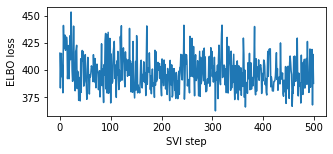

In [9]:
adam_params = {"lr": 0.05, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

losses = []
n_steps = 500
# do gradient steps
for step in range(n_steps):
    loss = svi.step(y.float())
    losses.append(loss)
    if step % 50 == 0:
        print("Elbo loss: {} for {}/{}".format(loss, step, n_steps))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")
plt.show()

we can visualize the estimated variational mean of slopes and compare them to the ground truth slopes:

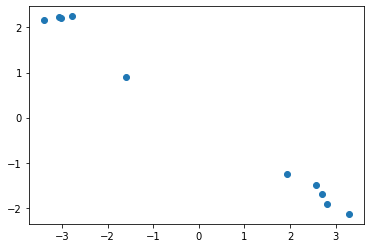

In [10]:
# scatter plot of estimated variational mean of slopes versus true slopes
est_slope = pyro.param("w_mu").data.cpu().numpy()
plt.scatter(est_slope, true_slope)
plt.show()


similar visualization with the variational mean of the latent variables

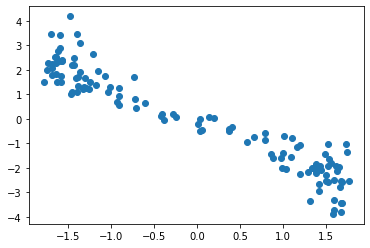

In [12]:
# scatter plot of estimated variational mean of latent variables versus true variables
est_x = pyro.param("x_mu").data.cpu().numpy()
plt.scatter(est_x, true_x)
plt.show()